# Basic Study Session - CV 
##  Assignment #1
이번 과제의 목표는 Faster R-CNN이 실제로 어떠한 구조로 돌아가는지 살펴보고 이해하기 위함입니다.

중간중간에 빈칸을 뚫어넣어 흐름을 따라갈 수 있게끔 만들었고, 나머지 부분은 큰 부담안가지시고 한번 쭉 돌려보시면 좋을 것 같습니다!

# Faster R-CNN Implementations by Pytorch

**Reference** : [How FasterRCNN works and step-by-step PyTorch implementation](https://youtu.be/4yOcsWg-7g8)

In [50]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

## Dependencies

In [51]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [52]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(DEVICE, torch.cuda.get_device_name(0))
else:
    DEVICE = torch.device("cpu")
    print(DEVICE)

cpu


## Data Preprocessing

### 1) Visualize image and bounding boxes

(1333, 2000, 3)


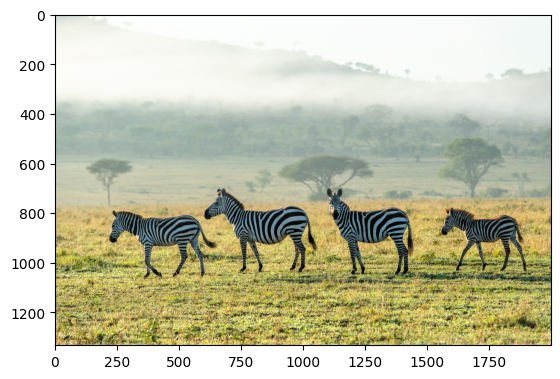

In [53]:
# In this example, only use 1 image, i.e, batch_size=1
# input image could be of any size

#####################################################
## Zebra image 경로 설정은 각자 Drive 경로에 맞게 해주세요. ##
#####################################################

img0 = cv2.imread("./zebras.jpg")

img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB) # BGR -> RGB
print(img0.shape) # (height : 1333, width : 2000, channel : 3)
plt.imshow(img0)
plt.show()

In [54]:
# Object information : a set of bounding boxes [x1, y1, x2, y2] 
# And their labels 

## Ground Truth ##
# 총 4개의 bbox, 얼룩말의 위치 좌표 [x_min, y_min, x_max, y_max]
# x_min, y_min은 bbox의 왼쪽 상단 모서리의 좌표, x_max, y_max은 bbox의 오른쪽 하단 모서리의 좌표
bbox0 = np.array([[223, 782, 623, 1074], [597, 695, 1038, 1050], 
                  [1088, 699, 1452, 1057], [1544, 771, 1914, 1063]]) 
labels = np.array([1, 1, 1, 1]) # 0: background, 1: zebra

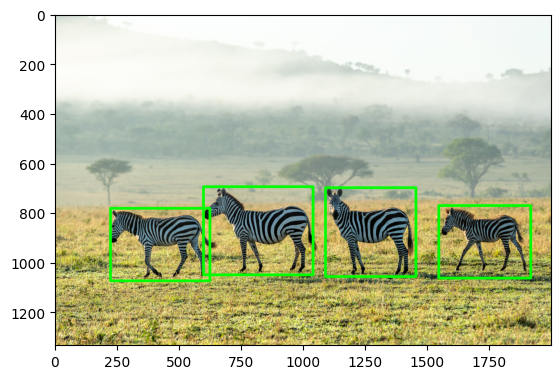

In [55]:
# Display bounding box and labels

img0_clone = np.copy(img0) # 복사본에 작업
for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][0], bbox0[i][1]), 
                              (bbox0[i][2], bbox0[i][3]),
                 color=(0, 255, 0), thickness=10)
plt.imshow(img0_clone)
plt.show()

### 2) Resize image and bounding boxes

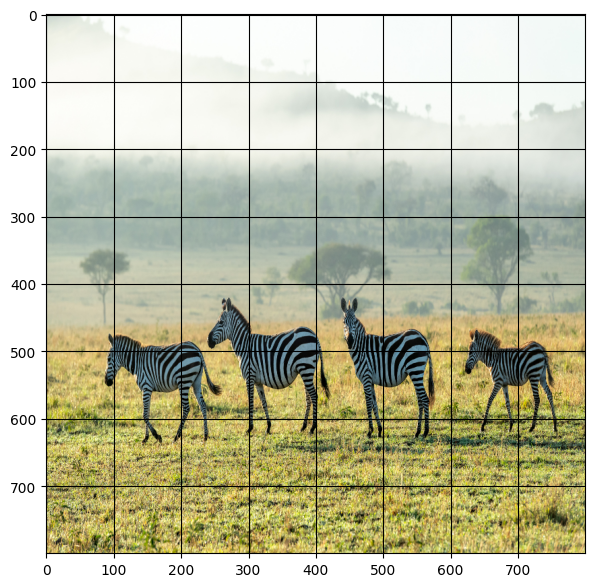

In [56]:
# Resize the input images to h=800, w=800

## 원본 resize ##
img = cv2.resize(img0, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
# 이미지의 품질을 유지하면서 크기를 변경하는 INTER_CUBIC 사용
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.grid(True, color="black")
plt.show()

0.4 0.6001500375093773
[[ 89 469 249 644]
 [238 417 415 630]
 [435 419 580 634]
 [617 462 765 637]]


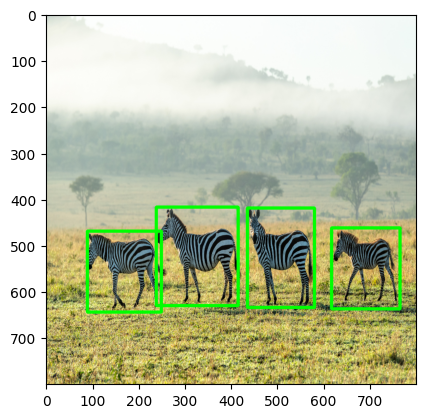

In [57]:
# Change the bounding box coordinates
# Original image size : (1333, 2000)


## Resize한 이미지에 맞게 Ground Truth도 위치 변경 ##

Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]

print(Wratio, Hratio) # 조정 비율 0.4 , 0.6

ratioList = [Wratio, Hratio, Wratio, Hratio]
bbox = []

for box in bbox0:
    box = [int(a*b) for a, b in zip(box, ratioList)]
    bbox.append(box)
    
bbox = np.array(bbox)
print(bbox) # 크기 조정된 이미지에서 bbox 의 GT 좌표

img_clone = np.copy(img)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), color=(0, 255, 0), thickness=5)
plt.imshow(img_clone)
plt.show()

## Define Feature extractor

### 1) Load pretrained VGG16

In [58]:
# Only print feature extraction part of VGG16

model = torchvision.models.vgg16(pretrained=True).to(DEVICE) #  VGG-16 모델
features = list(model.features)
print(len(features)) # 특징 layer 개수 31개
print(features) # conv layer은 이미지에서 특징 추출, max pooling layer에선 크기 줄이기, relu layer에서 비선형성 도입
                # VGG-16은 13개의 conv layer, 5개의 max pooling layer, 13개의 relu layer로 구성

c:\Users\badr1\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\badr1\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


31
[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

### 2) Only collect required layers

### 과제 1. Sub sampling ratio에 맞게 feature map을 출력하는 layer 찾기

In [59]:
print(output.size())

torch.Size([1, 512, 25, 25])


In [60]:
# Only collect layers with output feature map size (W, H) < 50

#####################################################
# Sub sampling ratio를 1/16이라 할때, 50*50 크기가 되는 layer까지만 feature extractor로 사용하려 합니다. (원본 800*800)
# 아래의 #####에 적절한 코드를 넣어주시면 됩니다 
#####################################################

dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array
print(dummy_img.shape) # torch.Size([1, 3, 800, 800])

req_features = []
output = dummy_img.clone().to(DEVICE)

for feature in features:
    output = feature(output)
    # 힌트: print(output.size())를 해보세요! -> 각각의 값들이 의미하는 바가 무엇일까요? CNN에 들어가는 tensor의 형태를 생각해보시면 됩니다. 
    # print(output.size()) : torch.Size([1, 512, 25, 25]) -> 25*25 크기의 feature map이 나옴
    if output.size()[2] < 50: # output feature map의 높이,너비 제한되도록
        break
    req_features.append(feature) # 원본 이미지 크기를 기준으로 50*50 이하로 축소된 feature map을 생성하는 layer만을 선택하여 저장하는 리스트
    out_channels = output.size()[1] # output feature map의 channel 수 512개의 다른 feature map 생성
    
print(len(req_features)) # 원래 31개였는데 30개면 1개만 걸러진 건가..?
print(req_features)
print(out_channels)

torch.Size([1, 3, 800, 800])


30
[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [61]:
# Convert this list into a Seqeuntial module
# 신경망 계층을 순차적으로 연결하는 nn.Sequential 모듈
faster_rcnn_feature_extractor = nn.Sequential(*req_features)
faster_rcnn_feature_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [62]:
# Test the results of the input image pass through the feature extractor

transform = transforms.Compose([transforms.ToTensor()]) # 이미지를 tensor로 변환
imgTensor = transform(img).to(DEVICE) # 이미지를 tensor로 변환 후 DEVICE에 할당
imgTensor = imgTensor.unsqueeze(0) # 이미지를 batch_size=1로 만들기 위해 차원 추가
output_map = faster_rcnn_feature_extractor(imgTensor) # feature extractor에 이미지를 넣어 feature map 생성

print(output_map.size())

torch.Size([1, 512, 50, 50])


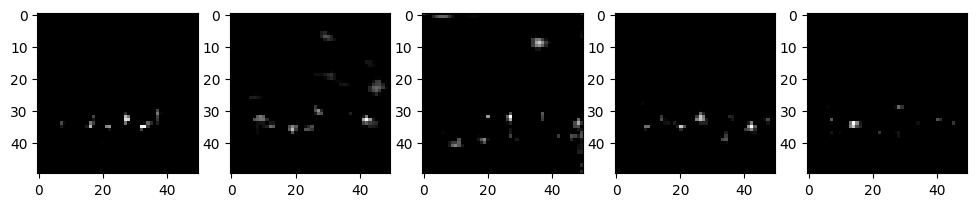

In [63]:
# Visualize the first 5 channels of the 50*50*512 feature maps

imgArray = output_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12, 4))
figNo = 1

for i in range(5):
    fig.add_subplot(1, 5, figNo)
    plt.imshow(imgArray[i], cmap='gray')
    figNo += 1
    
plt.show()

## Generate Anchors Boxes

### 1) Generate Anchors

In [64]:
# Sub-sampling rate = 1/16
# Image size : 800x800
# Sub-sampled feature map size : 800 x 1/16 = 50
# 50 x 50 = 2500 anchors and each anchor generate 9 anchor boxes
# Total anchor boxes = 50 x 50 x 9 = 22500
# x,y intervals to generate anchor box center

feature_size = 800 // 16 # 50
ctr_x = np.arange(16, (feature_size + 1) * 16, 16) # 중심좌표 생성, 각 cell의 중심점의 x,y좌표
ctr_y = np.arange(16, (feature_size + 1) * 16, 16) # 각 cell의 중심점은 16 pixel 간격으로 배치
print(len(ctr_x))
print(ctr_x)

50
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [65]:
# Anchor box를 생성하기 위한 2500개(50*50)의 중심좌표 찾기

index = 0
ctr = np.zeros((2500, 2)) # 50*50 크기의 feature map에는 2500개의 anchor box

for i in range(len(ctr_x)):
    for j in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[i] - 8 # 한개의 grid cell의 크기 16 -> cell의 중앙
        ctr[index, 0] = ctr_y[j] - 8
        index += 1

# ctr => [[center x, center y], ...]
print(ctr.shape)
print(ctr[:10, :])

(2500, 2)
[[  8.   8.]
 [ 24.   8.]
 [ 40.   8.]
 [ 56.   8.]
 [ 72.   8.]
 [ 88.   8.]
 [104.   8.]
 [120.   8.]
 [136.   8.]
 [152.   8.]]


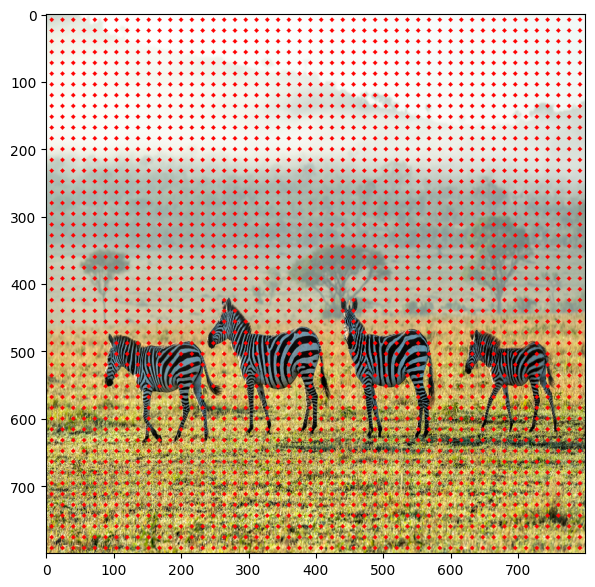

In [66]:
# Display the 2500 anchors within image

img_clone2 = np.copy(img)
ctr_int = ctr.astype("int32")

plt.figure(figsize=(7, 7))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone2, (ctr_int[i][0], ctr_int[i][1]),
              radius=1, color=(255, 0, 0), thickness=3)
plt.imshow(img_clone2)
plt.show()

### 2) Generate Anchor boxes

In [67]:
# 각 anchor당 9개의 anchor boxes 생성
# 2500 x 9 = 22500 anchor boxes

ratios = [0.5, 1, 2] # anchor box의 가로 세로 비율
scales = [8, 16, 32] # anchor box의 크기
sub_sample = 16

anchor_boxes = np.zeros(((feature_size * feature_size * 9), 4)) # 3개의 ratio, 3개의 scale, 50*50개의 cell, 각 cell당 9개의 anchor box
index = 0
# 모든 비율과 크기에 대해 anchor box 계산
for c in ctr:                        # per anchors
    ctr_y, ctr_x = c
    for i in range(len(ratios)):     # per ratios
        for j in range(len(scales)): # per scales
            
            # Anchor box height, width
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
            
            # Anchor box [x1, y1, x2, y2] <- x1,y1 : 좌상단 / x2,y2 : 우하단 
            anchor_boxes[index, 1] = ctr_y - h / 2.
            anchor_boxes[index, 0] = ctr_x - w / 2.
            anchor_boxes[index, 3] = ctr_y + h / 2.
            anchor_boxes[index, 2] = ctr_x + w / 2.
            index += 1
            
print(anchor_boxes.shape) # feature_size * feature_size * 9 = 22500
print(anchor_boxes[:10, :]) # anchor box의 좌상단, 우하단 좌표

(22500, 4)
[[ -82.50966799  -37.254834     98.50966799   53.254834  ]
 [-173.01933598  -82.50966799  189.01933598   98.50966799]
 [-354.03867197 -173.01933598  370.03867197  189.01933598]
 [ -56.          -56.           72.           72.        ]
 [-120.         -120.          136.          136.        ]
 [-248.         -248.          264.          264.        ]
 [ -37.254834    -82.50966799   53.254834     98.50966799]
 [ -82.50966799 -173.01933598   98.50966799  189.01933598]
 [-173.01933598 -354.03867197  189.01933598  370.03867197]
 [ -82.50966799  -21.254834     98.50966799   69.254834  ]]


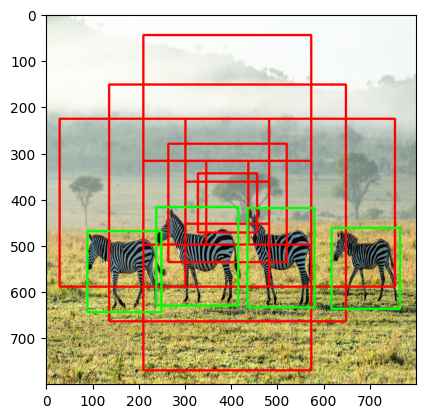

In [68]:
# Display the anchor boxes of one anchor and the ground truth boxes

img_clone = np.copy(img)

# draw random anchor boxes
for i in range(11025, 11034): # 22500개의 anchor box 중 11025~11034번째 anchor box
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 0, 0),
                 thickness=3)

# draw ground truth boxes
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), 
                             (bbox[i][2], bbox[i][3]),
                 color=(0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

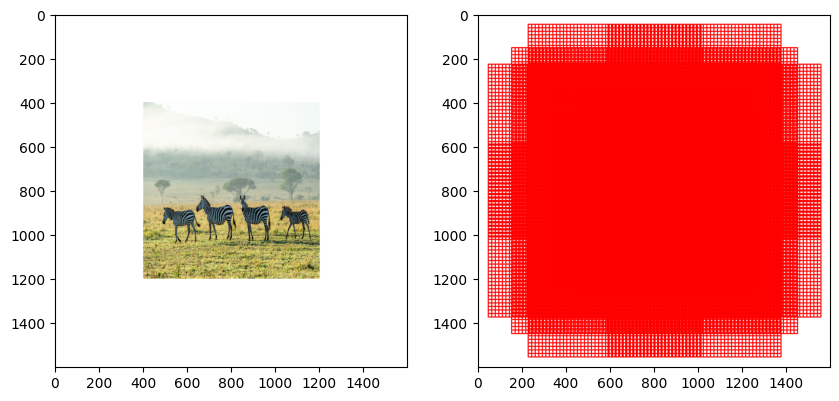

In [69]:
# Draw all anchor boxes

# Add paddings(can't draw anchor boxes out of image boundary) <- 이미지 밖으로 나가는 anchor box 분명히 생김 
img_clone3 = np.copy(img)
img_clone4 = cv2.copyMakeBorder(img_clone3,400,400,400,400,cv2.BORDER_CONSTANT, value=(255, 255, 255)) # 이미지 주변 여백 추가
img_clone5 = np.copy(img_clone4)

for i in range(len(anchor_boxes)):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone5, (x1+400, y1+400), (x2+400, y2+400), color=(255, 0, 0),
                 thickness=3) # 여백만큼 좌표 조정

plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(img_clone4)
plt.subplot(122), plt.imshow(img_clone5)
plt.show()

## Target Anchors

### 1) Only choose anchor boxes inside the image

In [70]:
# 이미지 경계 밖으로 나가는 anchor boxes 모두 제거 
# Valid anchor boxes with (x1, y1) > 0 and (x2, y2) <= 800

index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 800) &
        (anchor_boxes[:, 3] <= 800))[0]

print(index_inside.shape)

# Only 8940 anchor boxes are inside the boundary out of 22500
valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940,)
(8940, 4)


### 2) Calculate IoUs

In [71]:
# 8940개의 anchor boxes와 4개의 Ground truth objects, 이들간의 IoU를 계산해보자 

# Since we have 8940 anchor boxes and 4 ground truth objects,
# We should get an array with (8940, 4) as the output
# [IoU with gt box1, IoU with gt box2, IoU with gt box3,IoU with gt box4]

ious = np.empty((len(valid_anchor_boxes),4), dtype=np.float32)
ious.fill(0)

# anchor boxes
for i, anchor_box in enumerate(valid_anchor_boxes):
    xa1, ya1, xa2, ya2 = anchor_box
    anchor_area = (xa2 - xa1) * (ya2 - ya1)
    
    # ground truth boxes
    for j, gt_box in enumerate(bbox):
        xb1, yb1, xb2, yb2 = gt_box
        box_area = (xb2 - xb1) * (yb2 - yb1)
        
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2): # 교집합이 존재하는 경우
            inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
            iou = inter_area / (anchor_area + box_area - inter_area)
        else:
            iou = 0
        
        ious[i, j] = iou
        
print(ious.shape)
print(ious[8930:8940, :])

(8940, 4)
[[0.         0.         0.         0.37780452]
 [0.         0.         0.         0.33321926]
 [0.         0.         0.         0.29009855]
 [0.         0.         0.         0.24967977]
 [0.         0.         0.         0.2117167 ]
 [0.         0.         0.         0.17599213]
 [0.         0.         0.         0.14231375]
 [0.         0.         0.         0.11051063]
 [0.         0.         0.         0.08043041]
 [0.         0.         0.         0.05193678]]


### 3) Sample positive/negative anchor boxes

In [72]:
# What anchor box has max Iou with the ground truth box
# 각 Ground Truth box와 Iou가 최대인 anchor box 찾기 (행방향 탐색)

gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious) # 가장 큰 iou를 가진 anchor box의 index

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious) # 가장 큰 iou # 0.7이 안되나..?

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious) # gt_max_ious와 일치하는 모든 값의 인덱스

[1008 2862 5935 8699]
[0.58514285 0.5752716  0.5255493  0.6325869 ]
[1008 1013 1018 1226 1232 1238 2862 2869 2876 3108 3115 3122 3336 3343
 3350 3354 3357 3361 3364 3368 3371 3377 3383 3389 3600 3607 3614 3846
 3853 3860 5935 5942 6164 6171 6178 6181 6185 6188 6192 6198 6427 6434
 8699 8703 8707]


In [73]:
# What ground truth bbox is associated with each anchor box
# 개별 G.T(Ground Truth)와 anchor box들간의 관계(열방향 탐색)

argmax_ious = ious.argmax(axis=1) # 각 anchor box에 대해 가장 높은 IoU 값을 가지는 ground truth bbox의 인덱스
print(argmax_ious.shape)
print(argmax_ious)

max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious) # 유효한 anchor box에 대한 가장 높은 IoU 값

(8940,)
[0 0 0 ... 3 3 3]
[0.         0.         0.         ... 0.11051063 0.08043041 0.05193678]


In [74]:
# Set the labels of 8940 valid anchor boxes to -1(ignore)

# Anchor labeling(positive/negative) 이전 라벨 초기화 
label = np.empty((len(index_inside),), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [75]:
# Use IoU to assign 1 (objects) to two kind of anchors
# a) The anchors with the highest IoU overlap with a ground truth box <- G.T와의 IoU가 가장 높은 anchor
# b) An anchor that has an IoU overlap higher than 0.7 with ground truth box <- G.T와의 IoU가 0.7 이상인 anchor 
# >>> Positive anchor 

# Assign 0 (background) to an anchor if its IoU ratio is lower than 0.3 <- G.T와의 IoU가 0.3 이하인 anchor 
# >> Negative anchor 

pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

In [76]:
# Every time mini-batch training take only 256 valid anchor boxes to train RPN
# of which 128 positive examples, 128 negative-examples
# disable leftover positive/negative anchors 


# RPN을 훈련시킬때 256개의 mini batch를 사용하는데 비율을 최대한 맞춰서 간다 128/128(positive/negative)

n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample

pos_index = np.where(label == 1)[0]

# 남는 positive, negative sample들 label 변수에 -1로 저장 
# 하지만 일반적으로 positive sample의 수가 128개 미만일 경우, 부족한만큼의 sample을 negative sample에서 추출함. 

if len(pos_index) > n_pos: 
    disable_index = np.random.choice(pos_index,
                                    size = (len(pos_index) - n_pos),
                                    replace=False)
    label[disable_index] = -1
    
n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]

if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, 
                                    size = (len(neg_index) - n_neg), 
                                    replace = False)
    label[disable_index] = -1

In [77]:
# Convert the format of valid anchor boxes [x1, y1, x2, y2] <- anchor box의 Location

# For each valid anchor box, find the groundtruth object which has max_iou 
# 유효한 각 anchor box에 대해 최대 IoU를 가지는 groundtruth 찾는다.

max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

height = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
width = valid_anchor_boxes[:, 2] = valid_anchor_boxes[:, 0]
ctr_y = valid_anchor_boxes[:, 1] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 0] + 0.5 * width

base_height = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_width = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_ctr_y = max_iou_bbox[:, 1] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 0] + 0.5 * base_width

eps = np.finfo(height.dtype).eps # 부동 소수점 연산에서 사용
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

anchor_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(anchor_locs.shape)

(8940, 4)
(8940, 4)


In [78]:
# First set the label=-1 and locations=0 of the 22500 anchor boxes, (라벨 및 위치 초기화)
# and then fill in the locations and labels of the 8940 valid anchor boxes (유효한 박스들 location 및 label 채워넣기 )
# NOTICE: For each training epoch, we randomly select 128 positive + 128 negative 
# from 8940 valid anchor boxes, and the others are marked with -1 (유효하지 않은 anchor box)

anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)
print(anchor_labels[:10])

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)
print(anchor_locations[:10, :]) # 유효한 anchor box들의 location

(22500,)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(22500, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


## RPN(Region Proposal Network)

### 1) Define RPN

### 과제 2. reg_layer, cls_layer 맞추기 

In [107]:
# Send the features of the input image to the Region Proposal Network (RPN), 
# predict 22500 region proposals (ROIs)

#####################################################
# RPN 네트워크를 구성하는 문제입니다. 1*1 conv를 할때 output channel이 어떻게 되는지 맞춰보세요!
# 아래의 #####에 적절한 코드를 넣어주시면 됩니다 
#####################################################

in_channels = 512
mid_channels = 512
n_anchor = 9

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(DEVICE) 
conv1.weight.data.normal_(0, 0.01) # 가중치 초기화
conv1.bias.data.zero_() # bias 초기화

# bounding box regressor
reg_layer = nn.Conv2d(mid_channels, 36, 1, 1, 0).to(DEVICE) 
# 각 anchor box에 대해 4개의 좌표값을 예측(출력 channel이 4), 1*1 conv
# anchor box는 총 9개이므로 36개의 출력 channel
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

# classifier(object or not)
cls_layer = nn.Conv2d(mid_channels, 18, 1, 1, 0).to(DEVICE) 
# 각 anchor box에 대해 2개의 클래스를 예측,이진분류(출력 channel이 2), 1*1 conv
# anchor box는 총 9개이므로 18개의 출력 channel
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### 2) Classification and Bounding box regression

In [116]:
x = conv1(output_map.to(DEVICE)) # output_map = faster_rcnn_feature_extractor(imgTensor)
pred_anchor_locs = reg_layer(x) # bounding box regresor output
pred_cls_scores = cls_layer(x)  # classifier output 
# feature map을 conv layer 통과시켜 예측값을 구함
# bbox 위치 조정 예측, object or not 예측
print(pred_anchor_locs.shape, pred_cls_scores.shape) # 예측 결과의 차원은 각각 4, 2

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [117]:
pred_cls_scores.shape

torch.Size([1, 18, 50, 50])

In [118]:
# RPN의 tensor 형태를 anchor box에 맞게 변환 
# Position: [1, 36, 50, 50] => [1, 22500, 4] (dy, dx, dh, dw) 
# Classification: [1, 18, 50, 50] => [1, 22500, 2] (obj or no obj)

# (배치 크기, 높이, 너비, 앵커 개수 * 4) -> (배치 크기, 높이, 너비 ,앵커 개수* 4)
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

# (배치 크기, 높이, 너비, 앵커 개수 * 2) -> (배치 크기, 높이, 너비 ,앵커 개수* 2)
pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

# [1, 18, 50, 50] -> [1, 50, 50, 9, 2] 로 변경하여 마지막 차원에서 object 인지 아닌지 여부를 나타냄
objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

# [1, 18, 50, 50] -> [1, 22500, 2]로 변경하여 -1 은 anchor 수에 따라 자동 계산
pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


In [119]:
# According to the 22500 ROIs predicted by RPN and 22500 anchor boxes, 
# calculate the RPN loss¶

print(pred_anchor_locs.shape) # 위치 좌표 4개, anchor box 22500개
print(pred_cls_scores.shape) # object or not 2개, anchor box 22500개
print(anchor_locations.shape) # 좌표
print(anchor_labels.shape) # class label

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [120]:
rpn_loc = pred_anchor_locs[0] # 예측된 anchor box의 위치 좌표
rpn_score = pred_cls_scores[0] # 예측된 anchor box의 object or not

gt_rpn_loc = torch.from_numpy(anchor_locations) # ground truth anchor box의 위치 좌표
gt_rpn_score = torch.from_numpy(anchor_labels) # ground truth anchor box의 object or not

print(rpn_loc.shape, rpn_score.shape,
      gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


### 3) Multi-task loss

###  과제 3 : RPN loss 계산하기 

In [121]:
# For classification we use cross-entropy loss
# 예측된 class 점수 rpn_score와 실제 gt_rpn_score 사이의 cross-entropy loss 계산
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(DEVICE), ignore_index = -1)
print(rpn_cls_loss)

tensor(0.6995, grad_fn=<NllLossBackward0>)


In [122]:
# only positive samples
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

# take those bounding boxes whick have positive labels <- postivie sample에 대해서만 regression loss 계산 
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

#####################################################
## Regression Loss의 계산식을 물어보는 문제입니다.
## 강의자료의 smooth L1 계산식 참조 
## rpn_cls_loss와 rpn_reg_loss를 가지고 최종 loss를 계산해보세요 
#####################################################

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu()) #절댓값 씌워주기 
rpn_loc_loss = ((x < 1).float() * (0.5 * x ** 2)) + ((x >= 1).float() * (x - 0.5))
print(rpn_loc_loss.sum())

torch.Size([22500, 4])
torch.Size([45, 4]) torch.Size([45, 4])
tensor(16.6870, dtype=torch.float64, grad_fn=<SumBackward0>)


In [123]:
rpn_lambda = 10
N_reg = (gt_rpn_score > 0).float().sum() # positive anchor box의 개수
rpn_loc_loss = rpn_loc_loss.sum() / N_reg  # 회귀 손실의 평균
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss) # 최종 loss = classification loss + regression loss
print(rpn_loss)

tensor(4.4078, dtype=torch.float64, grad_fn=<AddBackward0>)


## Proposal layer

### 1) Transform anchor boxes

In [124]:
# RPN에서 추출한 ROI들 Fast RCNN으로 보내기 ->  predict bbox + classifications

nms_thresh = 0.7  # non-maximum supression (NMS) 어느정도 겹쳐야 하는지 임계값
n_train_pre_nms = 12000 # no. of train pre-NMS 훈련 중인 경우 RPN이 NMS를 적용하기 전에 유지할 ROI의 개수
n_train_post_nms = 2000 # after nms, training Fast R-CNN using 2000 RPN proposals 훈련 중에 사용할 ROI의 개수
n_test_pre_nms = 6000 # 테스트 중에는 최대 6,000개의 ROI를 유지
n_test_post_nms = 300 # During testing we evaluate 300 proposals,
min_size = 16

In [125]:
# the labelled 22500 anchor boxes
# format converted from [x1, y1, x2, y2] to [ctrx, ctry, w, h]
# anchor box의 중심 좌표와 크기 계산
anc_height = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_width = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_ctr_y = anchor_boxes[:, 1] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 0] + 0.5 * anc_width
print(anc_ctr_x.shape)

(22500,)


In [126]:
# The 22500 anchor boxes location and labels predicted by RPN (convert to numpy)
# format = (dx, dy, dw, dh)

# 예측된 anchor box의 위치 좌표,label 정보 배열로 변환
pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()

# 추출한 위치 정보 각각 변수에 저장
dy = pred_anchor_locs_numpy[:, 1::4]
dx = pred_anchor_locs_numpy[:, 0::4]
dh = pred_anchor_locs_numpy[:, 3::4]
dw = pred_anchor_locs_numpy[:, 2::4]
print(dy.shape)

(22500, 1)


In [127]:
# ctr_y = dy predicted by RPN * anchor_h + anchor_cy 
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h # anchor box의 높이
# w similar

# anchor box의 중심 x,y좌표, 높이, 너비
ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(22500, 1)


In [130]:
# Region of Interest (ROI) 좌표 계산

roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_x - 0.5 * w
roi[:, 1::4] = ctr_y - 0.5 * h
roi[:, 2::4] = ctr_x + 0.5 * w
roi[:, 3::4] = ctr_y + 0.5 * h

print(roi.shape)

(22500, 4)


### 2) Clip the anchor boxes to the image

In [131]:
# clip the predcited boxes to the image

img_size = (800, 800)
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0]) # [:, 0, 2] # 왼쪽 상단 x, 오른쪽 하단 x 좌표
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1]) # [:, 1, 3] # 왼쪽 상단 y, 오른쪽 하단 y 좌표

# 선택된 좌표를 0과 img_size[0], img_size[1] 사이에 clipping -> 이미지 경계를 벗어나지 않게
print(roi.shape, np.max(roi), np.min(roi))

(22500, 4) 800.0 0.0


In [132]:
# remove predicted boxes with either height or width < threshold
# 1차로 box 크기 기준치 미만 predicted box 삭제 

hs = roi[:, 3] - roi[:, 1] # roi 높이
ws = roi[:, 2] - roi[:, 0] # roi 너비

keep = np.where((hs >= min_size) & (ws >= min_size))[0] # 높이와 너비가 모두 min_size 이상인 ROI의 인덱스를 선택
roi = roi[keep, :]
score = objectness_score_numpy[keep] # 해당 ROI에 대한 objectness 점수를 선택
print(keep.shape, roi.shape, score.shape) # 하나도 제거가 안됐네..? 원래 그른가

(22500,) (22500, 4) (22500,)


### 3) Select top-12000 anchor boxes by objectness score

In [133]:
# sort all (proposal, score) pairs by score from highest to lowest
# objectness score를 바탕으로 anchor boxes 내림차순 정렬 (NMS전 필터링)

order = score.ravel().argsort()[::-1]
print(order.shape)

(22500,)


In [134]:
# take top pre_nms_topN (e.g. 12000 while training and 300 while testing)
# training에 사용될 roi 12000개
order = order[:n_train_pre_nms]
roi = roi[order, :]
print(order.shape, roi.shape)

(12000,) (12000, 4)


### 4) Non maximum suppression(select 2000 bounding boxes)

In [135]:
# take all the roi boxes
x1 = roi[:, 0]
y1 = roi[:, 1]
x2 = roi[:, 2]
y2 = roi[:, 3]

# find the areas of all the boxes

areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [136]:
# take the indexes of order the probability score in descending order
# NMS 진행하여 bbox 2000개까지 축소

order = order.argsort()[::-1]
keep = []

while (order.size > 0):
  i = order[0] # take the 1st elt in roder and append to keep
  keep.append(i)
# 나머지 ROI들과 선택한 첫 번째 ROI 간의 겹치는 영역을 계산 
  xx1 = np.maximum(x1[i], x1[order[1:]])
  yy1 = np.maximum(y1[i], y1[order[1:]])
  xx2 = np.minimum(x2[i], x2[order[1:]])
  yy2 = np.minimum(y2[i], y2[order[1:]])

  w = np.maximum(0.0, xx2 - xx1 + 1)
  h = np.maximum(0.0, yy2 - yy1 + 1)

  inter = w * h
  # IoU 계산
  ovr = inter / (areas[i] + areas[order[1:]] - inter)
  inds = np.where(ovr <= nms_thresh)[0] # IoU가 임계값보다 작은 ROI의 인덱스를 선택
  order = order[inds + 1]
# 겹치는 ROI들을 제거하고 상위 2000개의 ROI만을 선택
keep = keep[:n_train_post_nms] # while training/testing, use accordingly
roi = roi[keep]
print(len(keep), roi.shape)

2000 (2000, 4)


## Proposal Target layer

### 1) Calculate IoUs

In [140]:
# RPN에서 구한 ROI 중 Fast RCNN training에 유용한 sample 다시 선택 

n_sample = 128 # number of samples from roi
pos_ratio = 0.25 # number of positive examples out of the n_samples
pos_iou_thresh = 0.5 # min iou of region proposal with any ground truth object to consider it as positive label
neg_iou_thresh_hi = 0.5 # iou 0~0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [138]:
# fine the iou of each ground truth object with the region proposals

ious = np.empty((len(roi), bbox.shape[0]), dtype = np.float32)
ious.fill(0)

for num1, i in enumerate(roi):
  ya1, xa1, ya2, xa2 = i
  anchor_area = (ya2 - ya1) * (xa2 - xa1) # 현재 ROI의 면적을 계산

  for num2, j in enumerate(bbox):
    yb1, xb1, yb2, xb2 = j
    box_area = (yb2 - yb1) * (xb2 - xb1)
    inter_x1 = max([xb1, xa1])
    inter_y1 = max([yb1, ya1])
    inter_x2 = min([xb2, xa2])
    inter_y2 = min([yb2, ya2])

    if (inter_x1 < inter_x2) and (inter_y1 < inter_y2): # 겹치는 영역이 존재하는 경우
      inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
      iou = inter_area / (anchor_area + box_area - inter_area)
    else:
      iou = 0
    ious[num1, num2] = iou # 각 ROI와 Ground Truth box의 IoU를 계산

print(ious.shape)

(2000, 4)


In [139]:
# find out whick ground truth has high IoU for each region proposal
# also find the maximum IoU

gt_assignment = ious.argmax(axis=1) # 각 ROI에 대해 가장 높은 IoU를 가지는 Ground Truth box의 인덱스를 선택
max_iou = ious.max(axis=1) # 각 ROI에 대한 최대 IoU를 선택

print(gt_assignment)
print(max_iou)

# assign the labels to each proposal
gt_roi_label = labels[gt_assignment] # 각 ROI에 대해 해당하는 실제 bbox label 선택
print(gt_roi_label)

[3 0 0 ... 0 0 0]
[0.06211016 0.         0.         ... 0.         0.         0.        ]
[1 1 1 ... 1 1 1]


### 2) Select foreground(positive) samples

In [141]:
# select the foreground rois as pre the pos_iou_thresh
# and n_sample x pos_ratio (128 x 0.25 = 32) foreground samples
# 128개의 sample을 mini batch로 구성하며 32개가 positive / 96개가 negative (배경이 object보다 많을 수 밖에 없음)

# 각 이미지에서 최대 32개의 positive ROI를 선택하고
# 이 중에서 IoU가 pos_iou_thresh 이상인 것들을 무작위로 선택하여 최종 positive ROI를 구성
pos_roi_per_image = 32
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))

if pos_index.size > 0:
  pos_index = np.random.choice(
      pos_index, size=pos_roi_per_this_image, replace=False)
  
print(pos_roi_per_this_image)
print(pos_index)

30
[1916  959  289 1084 1019  896 1947  291  208 1917  245  961  150  902
 1881  957  243 1510  960  242 1461 1018  288  248  209 1556  207  148
  899  897]


### 3) Select background(negative) samples

In [142]:
# similarly we do for negative(background) region proposals

neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                     (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))

if neg_index.size > 0:
  neg_index = np.random.choice(
    neg_index, size = neg_roi_per_this_image, replace=False)
  
print(neg_roi_per_this_image)
print(neg_index)

98
[1305  911 1394 1817 1294 1129 1233  969  259  524  121  597  450    4
  775 1974   30 1073  493  698  217  903 1316  216  553 1594  673 1856
  366  847  572  721  328 1982 1584 1953  842 1061  558 1378 1819 1829
 1770 1195  183  281 1405 1110  279  617 1858  666   76  430   74 1410
 1463 1466  359 1948  765 1848  818  858  478 1707  728 1638 1921   25
 1089  442  849 1989 1522 1225 1623  873  403 1130 1656  350  116   32
 1968 1901 1682  182  626 1284 1966  630 1650 1777 1884 1998  311 1013]


### 4) Visualization

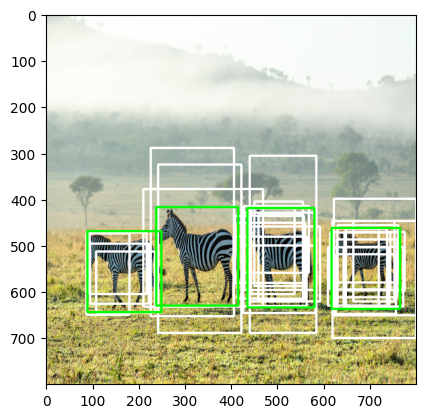

In [143]:
# display RoI samples with positive
# positive ROI와 실제 객체의 bbox를 함께 시각화

img_clone = np.copy(img)

for i in range(pos_roi_per_this_image):
  x1, y1, x2, y2 = roi[pos_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255,255,255),
                thickness=3)
  
for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

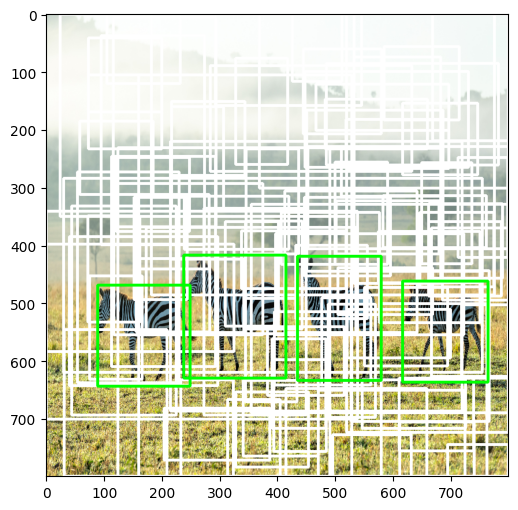

In [144]:
# display RoI samples with negative
# negative ROI와 실제 객체의 bbox를 함께 시각화
img_clone = np.copy(img)

plt.figure(figsize=(9, 6))

for i in range(neg_roi_per_this_image):
  x1, y1, x2, y2 = roi[neg_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 255, 255),
                thickness=3)
  
for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)
  
plt.imshow(img_clone)
plt.show()

### 5) Gather positive/negative samples

In [145]:
# now we gather positive samples index and negative samples index
# their respective labels and region proposals

keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0 # negative labels => 0
sample_roi = roi[keep_index]
print(sample_roi.shape) # 32개의 positive ROI와 96개의 negative ROI 좌표

(128, 4)


In [146]:
# pick the ground truth objects for these sample_roi and
# later parameterized as we have done while assigning locations to anchor boxes
# 선택한 sample에 해당하는 RoI 과 연결된 bbox
bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

(128, 4)


In [147]:
# 
width = sample_roi[:, 2] - sample_roi[:, 0]
height = sample_roi[:, 3] - sample_roi[:, 1]
ctr_x = sample_roi[:, 0] + 0.5 * width
ctr_y = sample_roi[:, 1] + 0.5 * height

base_width = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_height = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_x = bbox_for_sampled_roi[:, 0] + 0.5 * base_width
base_ctr_y = bbox_for_sampled_roi[:, 1] + 0.5 * base_height 

In [148]:
# transform anchor boxes
# 선택한 ROI의 위치를 연결된 bbox와 일치하도록 변환
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dx = (base_ctr_x - ctr_x) / width
dy = (base_ctr_y - ctr_y) / height
dw = np.log(base_width / width)
dh = np.log(base_height / height)

gt_roi_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(gt_roi_locs.shape)

(128, 4)


## RoI pooling

### 1) Concatenate labels with bbox coordinates

In [152]:
# Take out the features of 128 ROI samples

rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

torch.Size([128, 4]) torch.Size([128])


In [153]:
# RoI index와 좌표를 하나의 텐서로 합침
indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 5])


### 2) RoI pooling

In [154]:
# 7*7 size의 Feature map으로 통일 (max pooling)
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

In [155]:
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # sub-sampling ratio
rois = rois.long()
num_rois = rois.size(0)

for i in range(num_rois):
  roi = rois[i]
  im_idx = roi[0]
  im = output_map.narrow(0, im_idx, 1)[..., roi[1]:(roi[3]+1), roi[2]:(roi[4]+1)]
  tmp = adaptive_max_pool(im)
  output.append(tmp[0])

output = torch.cat(output, 0)

print(output.size())

torch.Size([128, 512, 7, 7])


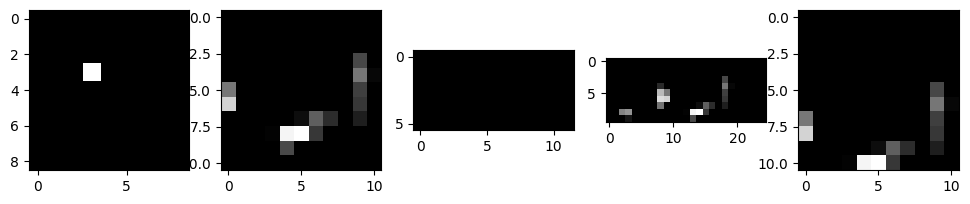

In [156]:
# Visualize the first 5 ROI's feature map (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = output_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    
    figNo +=1
plt.show()

In [157]:
# Reshape the tensor so that we can pass it through the feed forward layer.
k = output.view(output.size(0), -1)
print(k.shape) # 25088 = 7*7*512

torch.Size([128, 25088])


## Fast R-CNN

### 1) Classifier and Bounding box regressor

### 과제 4 :  Fast R-CNN classifier 계산

In [158]:
# 128개의 anchor boxes + (7x7x512) 사이즈의 ROI feature map이 detection network로 보내짐
# predict the objects bounding box and clas of the input image

#####################################################
## ROI pooling 이후 최종 bbox regression 및 classification을 위해 FC layer의 구성을 물어보는 문제입니다.
## 힌트: VGG의 Dense layer의 차원은 무엇이었을까요? 4096
#####################################################

roi_head_classifier = nn.Sequential(*[nn.Linear(25088  , 4096), 
                                    nn.Linear(4096, 4096)]).to(DEVICE)

#각 class 별로 bounding box coefficients를 예측하는 Bounding box regressor와 class score를 예측하는 Classifier를 정의
#주의! 모든 클래스(4개)가 아니라 각 class임 (cross entropy 계산할때 정답 클래스에 대해서만 계산하기 때문)

#Bounding box regresor
cls_loc = nn.Linear(4096, 2 * 4).to(DEVICE) # 2개의 클래스에 대해 각각 4개의 좌표값을 예측
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

#Classifier
score = nn.Linear(4096, 2).to(DEVICE) # 2개의 클래스에 대해 각각 object or not 예측


In [159]:
# passing the output of roi pooling to RoI head

k = roi_head_classifier(k.to(DEVICE))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)

print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 8]) torch.Size([128, 2])


In [160]:
# Calculate the loss of Fast RCNN based on the gt bboxes and features (h, w, d=512) 
# corresponding to these 128 ROIs

# predicted
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

#actual
print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


In [161]:
gt_roi_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### 2) Classification loss

In [162]:
# Converting ground truth to torch variable
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)

torch.Size([128, 4]) torch.Size([128])


### 3) Regression loss

In [163]:
# regression loss

n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

torch.Size([128, 2, 4])


In [164]:
roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

torch.Size([128, 4])


In [165]:
# for regression we use smooth l1 loss as defined in the Fast R-CNN paper
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

torch.Size([128, 4])


In [166]:
# take those bounding boxes which have positive labels
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(roi_loc_loss.sum())

torch.Size([30, 4]) torch.Size([30, 4])
tensor(14.1961, dtype=torch.float64, grad_fn=<SumBackward0>)


### 4) Multi-task loss

In [167]:
roi_lambda = 10.
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)
print(roi_loss)

total_loss = rpn_loss + roi_loss
print(total_loss)

tensor([[0.7047, 0.6909, 4.2819, 2.6078],
        [0.6934, 1.7374, 1.8095, 1.0569],
        [0.7125, 1.1760, 7.4713, 2.2430],
        [0.7191, 1.3583, 0.7237, 2.3069],
        [0.6856, 1.5756, 2.7259, 1.4382],
        [0.6894, 2.0112, 5.4691, 1.1424],
        [0.9522, 0.7175, 4.7931, 0.9777],
        [0.7009, 1.6567, 3.4950, 6.5769],
        [3.1357, 0.7280, 5.5922, 0.7671],
        [0.7641, 0.8566, 3.3197, 2.9088],
        [0.7461, 1.4702, 2.1566, 5.1205],
        [0.6856, 1.9111, 1.3563, 2.5236],
        [1.0170, 1.0795, 0.7687, 0.7290],
        [0.6930, 2.4443, 0.6929, 1.8678],
        [0.6937, 0.6855, 4.5318, 3.5467],
        [1.0580, 0.8660, 1.1823, 3.0367],
        [0.8301, 0.9514, 5.0416, 3.0077],
        [0.8596, 0.6921, 0.9818, 1.5790],
        [0.6878, 2.2818, 3.4067, 0.9695],
        [0.6868, 0.6867, 0.9388, 4.5583],
        [1.6615, 0.8420, 0.9465, 0.8146],
        [0.6912, 0.7127, 1.6708, 2.1546],
        [0.6928, 0.7228, 1.5387, 4.6556],
        [2.3980, 1.2916, 3.4085, 3